In [1]:
# Подключаем нбиблиотеки
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
# Создание Spark сесии
spark = SparkSession.builder.appName("covid").getOrCreate()

In [3]:
# Получим DataFrame из файла
spark_df = spark.read.csv(
    "./metadata.csv",
    header=True,
    inferSchema=True
)

# Для проверки выведем схуму данных
spark_df.printSchema()

root
 |-- patientid: string (nullable = true)
 |-- offset: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- finding: string (nullable = true)
 |-- RT_PCR_positive: string (nullable = true)
 |-- survival: string (nullable = true)
 |-- intubated: string (nullable = true)
 |-- intubation_present: string (nullable = true)
 |-- went_icu: string (nullable = true)
 |-- in_icu: string (nullable = true)
 |-- needed_supplemental_O2: string (nullable = true)
 |-- extubated: string (nullable = true)
 |-- temperature: double (nullable = true)
 |-- pO2_saturation: double (nullable = true)
 |-- leukocyte_count: double (nullable = true)
 |-- neutrophil_count: double (nullable = true)
 |-- lymphocyte_count: double (nullable = true)
 |-- view: string (nullable = true)
 |-- modality: string (nullable = true)
 |-- date: string (nullable = true)
 |-- location: string (nullable = true)
 |-- folder: string (nullable = true)
 |-- filename: string (nullable 

## Анализ качества данных

In [4]:
print("Количество строк:", spark_df.count())

Количество строк: 950


+--------------------+-------------+------------------+
|              column|missing_count|missing_percentage|
+--------------------+-------------+------------------+
|                _c29|          935| 98.42105263157895|
|     leukocyte_count|          934|  98.3157894736842|
|    neutrophil_count|          922| 97.05263157894737|
|           extubated|          913| 96.10526315789474|
|    lymphocyte_count|          910| 95.78947368421052|
|         temperature|          872| 91.78947368421052|
|needed_supplement...|          860| 90.52631578947368|
|      pO2_saturation|          831| 87.47368421052632|
|           intubated|          702| 73.89473684210527|
|  intubation_present|          700| 73.68421052631578|
|              in_icu|          615| 64.73684210526316|
|            survival|          589|              62.0|
|                 doi|          568| 59.78947368421053|
|            went_icu|          553| 58.21052631578948|
|         other_notes|          510| 53.68421052

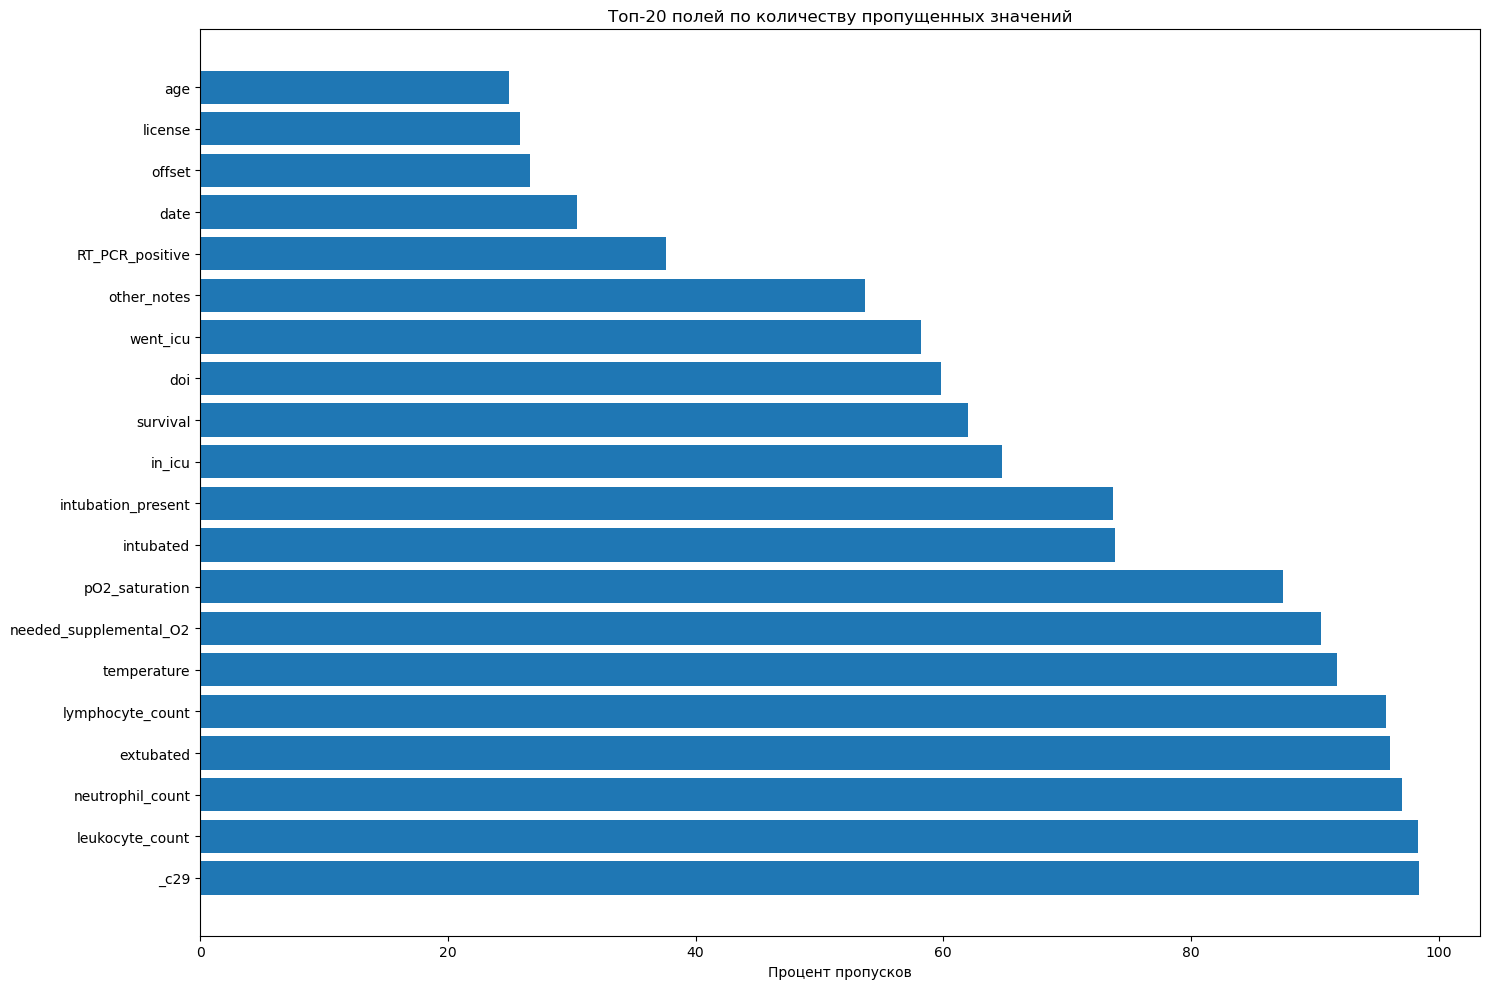

In [5]:
def missing_value_analysis(df):
    total_rows = df.count()
    missing_stats = []
    
    for column in df.columns:
        missing_count = df.filter(col(column).isNull()).count()
        missing_percentage = (missing_count / total_rows) * 100
        missing_stats.append({
            'column': column,
            'missing_count': missing_count,
            'missing_percentage': missing_percentage
        })
    
    missing_df = spark.createDataFrame(missing_stats)
    missing_df = missing_df.orderBy(col('missing_percentage').desc())
    return missing_df

missing_df = missing_value_analysis(spark_df)
missing_df.show(20)

# 4.2 Визуализация пропущенных значений
missing_pd = missing_df.toPandas()
plt.figure(figsize=(15, 10))
plt.barh(missing_pd['column'][:20], missing_pd['missing_percentage'][:20])
plt.xlabel('Процент пропусков')
plt.title('Топ-20 полей по количеству пропущенных значений')
plt.tight_layout()
plt.show()

Удалим колоки, в которых доля пропуска превышает 50%

In [6]:
missing_df.show()

+--------------------+-------------+------------------+
|              column|missing_count|missing_percentage|
+--------------------+-------------+------------------+
|                _c29|          935| 98.42105263157895|
|     leukocyte_count|          934|  98.3157894736842|
|    neutrophil_count|          922| 97.05263157894737|
|           extubated|          913| 96.10526315789474|
|    lymphocyte_count|          910| 95.78947368421052|
|         temperature|          872| 91.78947368421052|
|needed_supplement...|          860| 90.52631578947368|
|      pO2_saturation|          831| 87.47368421052632|
|           intubated|          702| 73.89473684210527|
|  intubation_present|          700| 73.68421052631578|
|              in_icu|          615| 64.73684210526316|
|            survival|          589|              62.0|
|                 doi|          568| 59.78947368421053|
|            went_icu|          553| 58.21052631578948|
|         other_notes|          510| 53.68421052

In [7]:
# Соберем список полей на удаление
drop_col_name = missing_df.filter(missing_df.missing_percentage > 50).select("column")
drop_list =  drop_col_name.rdd.flatMap(lambda x: x).collect()

# Так же удалим колонки "folder", "filename" и "url" из-за ненадобности
drop_list += ["folder", "filename", "url"]

# Удаляем все поля по списку
spark_df = spark_df.drop(*drop_list)

spark_df.printSchema()

root
 |-- patientid: string (nullable = true)
 |-- offset: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: integer (nullable = true)
 |-- finding: string (nullable = true)
 |-- RT_PCR_positive: string (nullable = true)
 |-- view: string (nullable = true)
 |-- modality: string (nullable = true)
 |-- date: string (nullable = true)
 |-- location: string (nullable = true)
 |-- license: string (nullable = true)
 |-- clinical_notes: string (nullable = true)



In [8]:
spark_df.select("RT_PCR_positive").distinct().show()

+---------------+
|RT_PCR_positive|
+---------------+
|              Y|
|        Unclear|
|           NULL|
+---------------+



Записей с неопределенным результатом ПЦР-теста слишком много для удаления. Далее буду обрабатывать как значение Unknown

In [9]:
spark_df.select("RT_PCR_positive").distinct().show()

+---------------+
|RT_PCR_positive|
+---------------+
|              Y|
|        Unclear|
|           NULL|
+---------------+



In [10]:
# Найдем медианное значение возрвста
median_age = spark_df.approxQuantile("age", [0.5], 0.01)

# Выполним заполнение пропусков
spark_df = spark_df.fillna({
    'offset': 0, # 0 для неизвестного возраста
    'age': 0, # 0 для неизвестного возраста
    'sex': 'Unknown',
    'finding': 'Not Specified',
    'RT_PCR_positive': 'Unknown',
    'view': 'Unknown',
    'modality': 'Unknown',
    'location': 'Unknown',
    'license': 'Unknown',
    'clinical_notes': 'Unknown'
})

missing_df = missing_value_analysis(spark_df)
missing_df.show(20)

+---------------+-------------+------------------+
|         column|missing_count|missing_percentage|
+---------------+-------------+------------------+
|           date|          289| 30.42105263157895|
|         offset|            0|               0.0|
|        license|            0|               0.0|
|            sex|            0|               0.0|
|       location|            0|               0.0|
| clinical_notes|            0|               0.0|
|       modality|            0|               0.0|
|           view|            0|               0.0|
|            age|            0|               0.0|
|      patientid|            0|               0.0|
|        finding|            0|               0.0|
|RT_PCR_positive|            0|               0.0|
+---------------+-------------+------------------+



In [11]:
# Проверим уникальные значения finding
spark_df.select('finding').distinct().show()

+--------------------+
|             finding|
+--------------------+
|Pneumonia/Bacteri...|
|Pneumonia/Aspiration|
|    Pneumonia/Lipoid|
|        Tuberculosis|
|Pneumonia/Fungal/...|
|Pneumonia/Bacteri...|
| Pneumonia/Bacterial|
|Pneumonia/Viral/M...|
|             Unknown|
|Pneumonia/Viral/V...|
|Pneumonia/Bacteri...|
|Pneumonia/Viral/I...|
|Pneumonia/Bacteri...|
|                todo|
|Pneumonia/Bacteri...|
|Pneumonia/Viral/I...|
|Pneumonia/Viral/C...|
|Pneumonia/Viral/SARS|
|Pneumonia/Bacteri...|
|Pneumonia/Fungal/...|
+--------------------+
only showing top 20 rows



In [12]:
# Унификация диагнозов
def unify_diagnosis(finding):
    if finding:
        finding = str(finding).lower()
        if 'covid' in finding:
            return 'COVID-19'
        elif 'sars' in finding and 'covid' not in finding:
            return 'SARS'
        elif 'pneumocystis' in finding or 'pjp' in finding.lower():
            return 'Pneumocystis pneumonia'
        elif 'streptococcus' in finding or 'pneumococcal' in finding.lower():
            return 'Streptococcal pneumonia'
        elif 'legionella' in finding:
            return 'Legionella pneumonia'
        elif 'klebsiella' in finding:
            return 'Klebsiella pneumonia'
        elif 'ards' in finding or 'acute respiratory distress' in finding:
            return 'ARDS'
        elif 'bacterial' in finding:
            return 'Bacterial pneumonia'
        elif 'viral' in finding:
            return 'Viral pneumonia'
        elif 'fungal' in finding:
            return 'Fungal pneumonia'
        elif 'pneumonia' in finding:
            return 'Pneumonia unspecified'
        else:
            return 'Other/No Finding'
    return 'Not Specified'

# Создание UDF для унификации диагнозов
unify_diagnosis_udf = udf(unify_diagnosis, StringType())
spark_df = spark_df.withColumn('unified_finding', unify_diagnosis_udf(col('finding')))

In [13]:
# Категоризация возраста
def categorize_age(age):
    if age <= 0:
        return 'Unknown'
    elif age <= 18:
        return '0-18'
    elif age <= 30:
        return '19-30'
    elif age <= 45:
        return '31-45'
    elif age <= 60:
        return '46-60'
    elif age <= 75:
        return '61-75'
    else:
        return '76+'

categorize_age_udf = udf(categorize_age, StringType())
spark_df = spark_df.withColumn('age_group', categorize_age_udf(col('age')))

In [14]:
# Удаление дубликатов по ключевым полям
spark_df = spark_df.dropDuplicates(['patientid', 'offset'])

print("Количество строк после обработки:", spark_df.count())

Количество строк после обработки: 766


In [15]:
# Анализ аномальных значений
# Проверка возраста
age_stats = spark_df.select(
    mean('age').alias('mean_age'),
    stddev('age').alias('std_age'),
    min('age').alias('min_age'),
    max('age').alias('max_age')
).collect()[0]

print(f"Статистика возраста:")
print(f"Среднее: {age_stats['mean_age']:.2f}")
print(f"Стандартное отклонение: {age_stats['std_age']:.2f}")
print(f"Минимум: {age_stats['min_age']}")
print(f"Максимум: {age_stats['max_age']}")

# Поиск аномальных значений возраста
spark_df.filter((col('age') < 0) | (col('age') > 120)).show()

Статистика возраста:
Среднее: 38.92
Стандартное отклонение: 28.38
Минимум: 0
Максимум: 94
+---------+------+---+---+-------+---------------+----+--------+----+--------+-------+--------------+---------------+---------+
|patientid|offset|sex|age|finding|RT_PCR_positive|view|modality|date|location|license|clinical_notes|unified_finding|age_group|
+---------+------+---+---+-------+---------------+----+--------+----+--------+-------+--------------+---------------+---------+
+---------+------+---+---+-------+---------------+----+--------+----+--------+-------+--------------+---------------+---------+



Аномальные значения в возрасте не обнаружены

In [16]:
# Анализ распределения пола
gender_dist = spark_df.groupBy('sex').count().orderBy(col('count').desc())
gender_dist.show()

+-------+-----+
|    sex|count|
+-------+-----+
|      M|  442|
|      F|  262|
|Unknown|   62|
+-------+-----+



Из 766:

- 442 пациента Мужского пола
- 262 пациента Эенского пола
- 62 пацента не указали пол

## SQL-аналитика

In [17]:
spark_df.createOrReplaceTempView("medical")

In [18]:
# Запрос 1: Базовая статистика по диагнозам
query1 = """
SELECT 
    unified_finding as diagnosis,
    COUNT(*) as total_cases,
    ROUND(AVG(age), 2) as avg_age,
    MIN(age) as min_age,
    MAX(age) as max_age
FROM medical
WHERE age > 0
GROUP BY unified_finding
ORDER BY total_cases DESC
"""

result1 = spark.sql(query1)
result1.show(truncate=False)

+-----------------------+-----------+-------+-------+-------+
|diagnosis              |total_cases|avg_age|min_age|max_age|
+-----------------------+-----------+-------+-------+-------+
|COVID-19               |360        |56.94  |20     |94     |
|Pneumonia unspecified  |63         |51.76  |18     |90     |
|Other/No Finding       |28         |48.93  |20     |78     |
|Bacterial pneumonia    |18         |51.33  |28     |80     |
|Streptococcal pneumonia|17         |41.76  |25     |75     |
|Pneumocystis pneumonia |17         |37.18  |25     |70     |
|SARS                   |16         |50.06  |23     |76     |
|Viral pneumonia        |12         |46.75  |26     |70     |
|Klebsiella pneumonia   |9          |55.11  |52     |62     |
|Legionella pneumonia   |9          |56.67  |45     |80     |
|Fungal pneumonia       |2          |24.0   |21     |27     |
+-----------------------+-----------+-------+-------+-------+



In [19]:
# Запрос 2: Распределение по полу и диагнозам
query2 = """
SELECT 
    unified_finding as diagnosis,
    sex,
    COUNT(*) as count,
    ROUND(COUNT(*) * 100.0 / SUM(COUNT(*)) OVER (PARTITION BY unified_finding), 2) as percentage
FROM medical
WHERE sex IN ('M', 'F')
GROUP BY unified_finding, sex
ORDER BY unified_finding, sex
"""

result2 = spark.sql(query2)
result2.show(truncate=False)

+-----------------------+---+-----+----------+
|diagnosis              |sex|count|percentage|
+-----------------------+---+-----+----------+
|Bacterial pneumonia    |F  |5    |27.78     |
|Bacterial pneumonia    |M  |13   |72.22     |
|COVID-19               |F  |152  |34.70     |
|COVID-19               |M  |286  |65.30     |
|Fungal pneumonia       |F  |1    |50.00     |
|Fungal pneumonia       |M  |1    |50.00     |
|Klebsiella pneumonia   |F  |2    |22.22     |
|Klebsiella pneumonia   |M  |7    |77.78     |
|Legionella pneumonia   |F  |3    |33.33     |
|Legionella pneumonia   |M  |6    |66.67     |
|Other/No Finding       |F  |34   |33.01     |
|Other/No Finding       |M  |69   |66.99     |
|Pneumocystis pneumonia |F  |1    |5.56      |
|Pneumocystis pneumonia |M  |17   |94.44     |
|Pneumonia unspecified  |F  |35   |55.56     |
|Pneumonia unspecified  |M  |28   |44.44     |
|SARS                   |F  |11   |68.75     |
|SARS                   |M  |5    |31.25     |
|Streptococca

In [20]:
# Запрос 3: Топ-3 по возрасту в каждой группе диагнозов
query3 = """
WITH ranked_patients AS (
    SELECT 
        patientid,
        unified_finding as diagnosis,
        age,
        sex,
        RT_PCR_positive,
        ROW_NUMBER() OVER (PARTITION BY unified_finding ORDER BY age DESC) as rank
    FROM medical
    WHERE age > 0
)
SELECT 
    diagnosis,
    patientid,
    age,
    sex,
    RT_PCR_positive,
    rank
FROM ranked_patients
WHERE rank <= 3
ORDER BY diagnosis, rank
"""

result3 = spark.sql(query3)
result3.show(truncate=False)

+----------------------+---------+---+---+---------------+----+
|diagnosis             |patientid|age|sex|RT_PCR_positive|rank|
+----------------------+---------+---+---+---------------+----+
|Bacterial pneumonia   |91       |80 |F  |Unknown        |1   |
|Bacterial pneumonia   |91       |80 |F  |Unknown        |2   |
|Bacterial pneumonia   |91       |80 |F  |Unknown        |3   |
|COVID-19              |326b     |94 |M  |Y              |1   |
|COVID-19              |324b     |93 |F  |Y              |2   |
|COVID-19              |324b     |93 |F  |Y              |3   |
|Fungal pneumonia      |411      |27 |M  |Unknown        |1   |
|Fungal pneumonia      |398      |21 |F  |Unknown        |2   |
|Klebsiella pneumonia  |100      |62 |F  |Unknown        |1   |
|Klebsiella pneumonia  |450      |62 |F  |Unknown        |2   |
|Klebsiella pneumonia  |463      |60 |M  |Unknown        |3   |
|Legionella pneumonia  |340      |80 |M  |Unknown        |1   |
|Legionella pneumonia  |110      |60 |M 

In [21]:
# Запрос 4: Анализ временных трендов по датам исследований
query4 = """
SELECT 
    YEAR(date) as year,
    MONTH(date) as month,
    unified_finding as diagnosis,
    COUNT(*) as total_cases,
    AVG(age) as avg_age
FROM medical
WHERE date IS NOT NULL AND date != ''
GROUP BY YEAR(date), MONTH(date), unified_finding
ORDER BY year, month, total_cases DESC
"""

result4 = spark.sql(query4)
result4.show(truncate=False)

+----+-----+-----------------------+-----------+------------------+
|year|month|diagnosis              |total_cases|avg_age           |
+----+-----+-----------------------+-----------+------------------+
|NULL|NULL |COVID-19               |72         |50.291666666666664|
|NULL|NULL |Pneumonia unspecified  |5          |52.0              |
|NULL|NULL |SARS                   |5          |33.6              |
|NULL|NULL |Pneumocystis pneumonia |4          |32.5              |
|NULL|NULL |Other/No Finding       |2          |78.0              |
|NULL|NULL |Streptococcal pneumonia|2          |47.5              |
|NULL|NULL |Klebsiella pneumonia   |1          |52.0              |
|NULL|NULL |Viral pneumonia        |1          |60.0              |
|2004|1    |SARS                   |11         |57.54545454545455 |
|2007|1    |Pneumocystis pneumonia |1          |0.0               |
|2010|1    |Pneumocystis pneumonia |2          |0.0               |
|2011|1    |Streptococcal pneumonia|3          |

In [22]:
# Запрос 5: Статистика по проекциям снимков и их связи с диагнозами
query5 = """
SELECT 
    view,
    unified_finding as diagnosis,
    COUNT(*) as total_cases,
    ROUND(AVG(age), 2) as avg_age,
    SUM(CASE WHEN RT_PCR_positive = 'Y' THEN 1 ELSE 0 END) as pcr_positive
FROM medical
WHERE view IS NOT NULL AND view != 'Unknown'
GROUP BY view, unified_finding
HAVING COUNT(*) > 5
ORDER BY view, total_cases DESC
"""

result5 = spark.sql(query5)
result5.show(truncate=False)

+---------+-----------------------+-----------+-------+------------+
|view     |diagnosis              |total_cases|avg_age|pcr_positive|
+---------+-----------------------+-----------+-------+------------+
|AP       |COVID-19               |133        |50.8   |106         |
|AP       |Pneumonia unspecified  |13         |52.38  |0           |
|AP       |Viral pneumonia        |9          |35.11  |0           |
|AP       |SARS                   |8          |66.63  |0           |
|AP       |Other/No Finding       |7          |56.29  |1           |
|AP Supine|COVID-19               |128        |39.18  |59          |
|AP Supine|Other/No Finding       |65         |2.22   |3           |
|AP Supine|Pneumonia unspecified  |10         |50.5   |0           |
|Axial    |COVID-19               |30         |44.07  |12          |
|PA       |COVID-19               |191        |38.63  |107         |
|PA       |Pneumonia unspecified  |41         |50.61  |0           |
|PA       |Other/No Finding       

## Обработка в PySpark 

In [23]:
# Фильтрация только COVID-19 случаев
covid_cases = spark_df.filter(col('unified_finding') == 'COVID-19')
print(f"Количество COVID-19 случаев: {covid_cases.count()}")

Количество COVID-19 случаев: 483


In [24]:
# Фильтрация по возрасту
adult_cases = spark_df.filter((col('age') >= 18) & (col('age') <= 65))
print(f"Количество случаев взрослых пациентов: {adult_cases.count()}")

Количество случаев взрослых пациентов: 390


In [25]:
# Сохранение в формате Parquet (оптимизированный формат)
spark_df.write.mode('overwrite').parquet('processed_medical_data.parquet')

# Сохранение в CSV для совместимости
spark_df.coalesce(1).write.mode('overwrite') \
    .option('header', 'true') \
    .csv('processed_medical_data.csv')

## Визуализация данных

In [27]:
# Для отрисовки графиков преобразуем в pandas
df_pd = spark_df.toPandas()

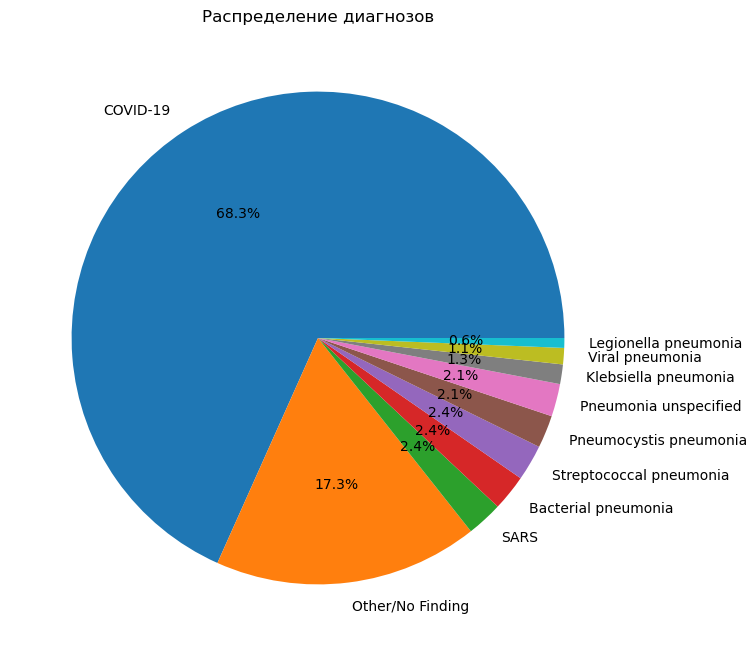

In [35]:
# Круговая диаграмма распределения диагнозов
plt.figure(figsize=(10, 8))
diagnosis_counts = df_pd['unified_finding'].value_counts()
plt.pie(diagnosis_counts.values, labels=diagnosis_counts.index, autopct='%1.1f%%')
plt.title('Распределение диагнозов')
plt.show()

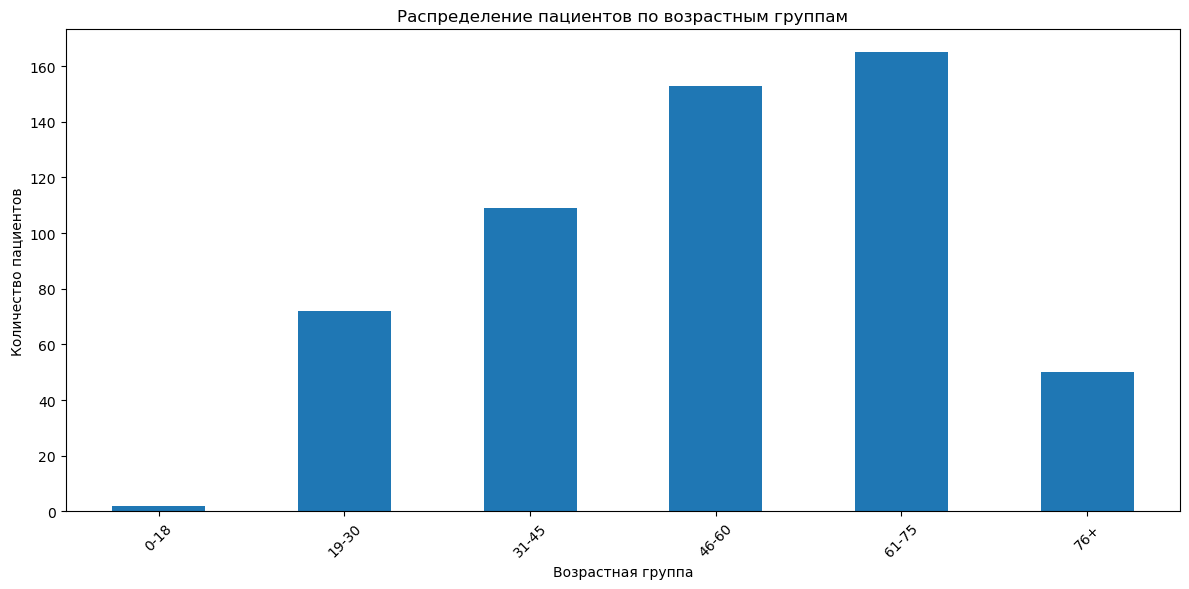

In [29]:
# Столбчатая диаграмма по возрастным группам
plt.figure(figsize=(12, 6))
age_group_counts = df_pd[df_pd['age_group'] != 'Unknown']['age_group'].value_counts()
age_group_counts = age_group_counts.reindex(['0-18', '19-30', '31-45', '46-60', '61-75', '76+'])
age_group_counts.plot(kind='bar')
plt.title('Распределение пациентов по возрастным группам')
plt.xlabel('Возрастная группа')
plt.ylabel('Количество пациентов')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

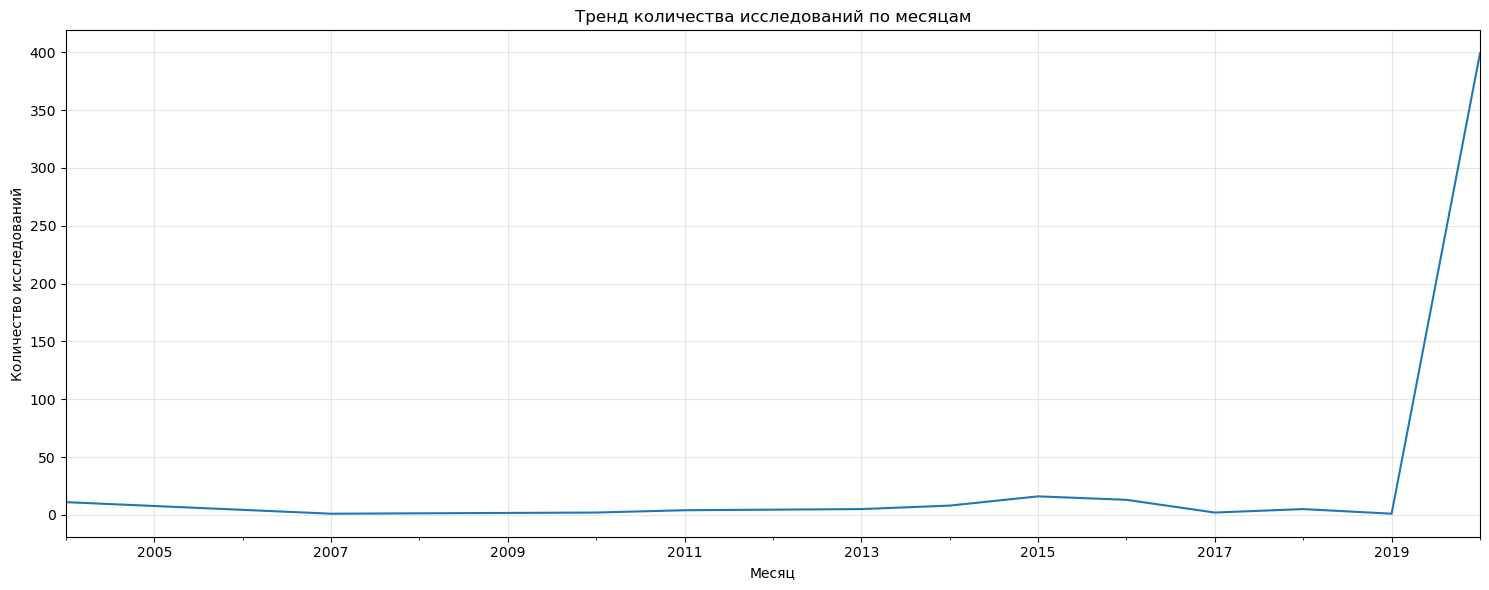

In [30]:
# График временных трендов (если есть данные о датах)
if 'date' in df_pd.columns:
    df_pd['date'] = pd.to_datetime(df_pd['date'], errors='coerce')
    df_pd = df_pd.dropna(subset=['date'])
    
    monthly_cases = df_pd.groupby(df_pd['date'].dt.to_period('M')).size()
    
    plt.figure(figsize=(15, 6))
    monthly_cases.plot()
    plt.title('Тренд количества исследований по месяцам')
    plt.xlabel('Месяц')
    plt.ylabel('Количество исследований')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

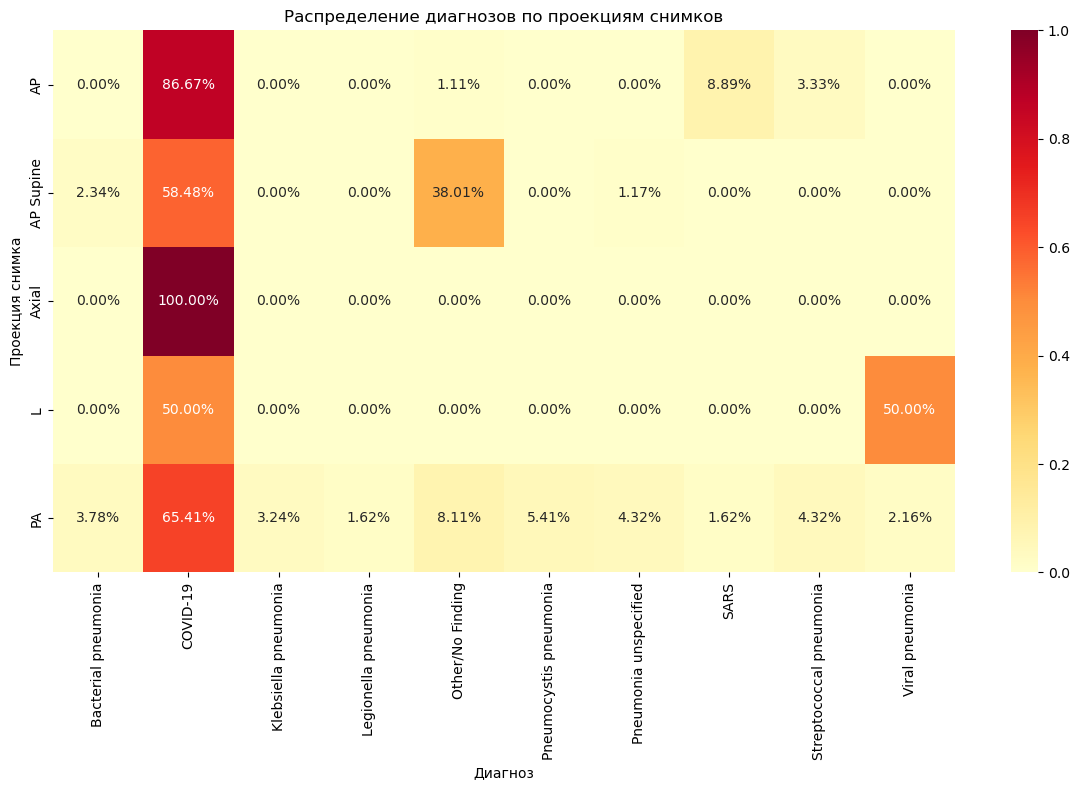

In [36]:
# Heatmap распределения диагнозов по проекциям снимков
plt.figure(figsize=(12, 8))
view_diagnosis_crosstab = pd.crosstab(
    df_pd['view'], 
    df_pd['unified_finding'],
    normalize='index'
)
sns.heatmap(view_diagnosis_crosstab, annot=True, fmt='.2%', cmap='YlOrRd')
plt.title('Распределение диагнозов по проекциям снимков')
plt.xlabel('Диагноз')
plt.ylabel('Проекция снимка')
plt.tight_layout()
plt.show()

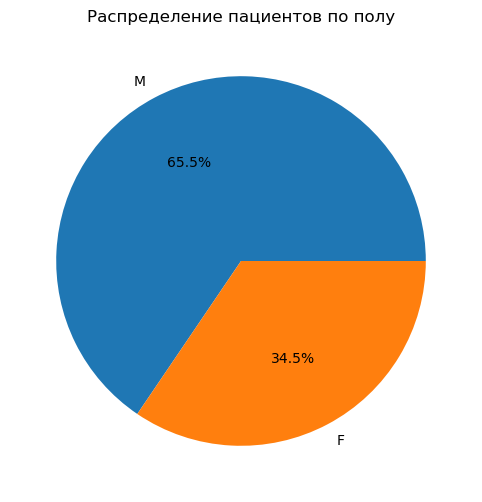

In [34]:
# Дополнительная визуализация: распределение по полу
plt.figure(figsize=(10, 6))
gender_dist_pd = df_pd[df_pd['sex'].isin(['M', 'F'])]['sex'].value_counts()
gender_dist_pd.plot(kind='pie', autopct='%1.1f%%')
plt.title('Распределение пациентов по полу')
plt.ylabel('')
plt.show()

In [ ]:
# Завершение Spark сессии
spark.stop()